# Домашнее задание №2. Элементарные методы анализа временных рядов

In [1]:
import pandas as pd
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd '/content/drive/MyDrive/Colab_Notebooks/Netology/TimeSeries/Data'

/content/drive/MyDrive/Colab_Notebooks/Netology/TimeSeries/Data


In [107]:
mean_monthly_temp = pd.read_csv("Series/mean-monthly-air-temperature-deg.csv")

In [108]:
import matplotlib.pyplot as plt
%matplotlib inline

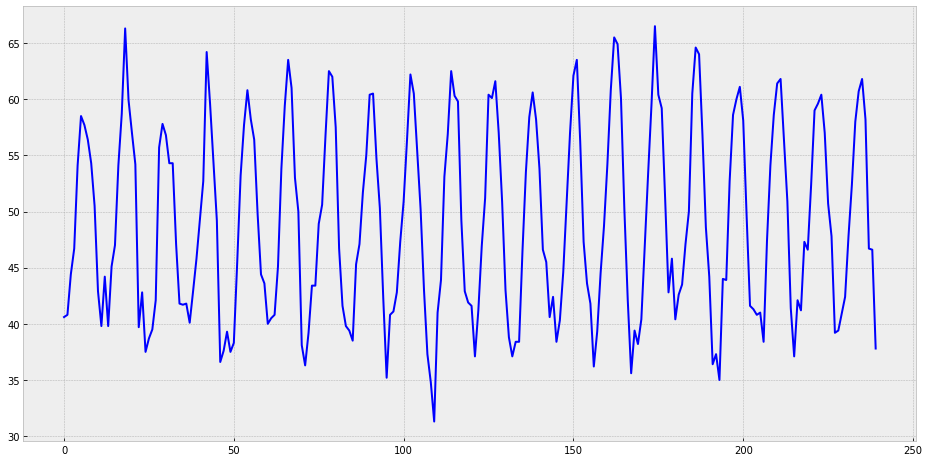

In [109]:
with plt.style.context('bmh'):
        plt.figure(figsize=(16, 8))
        plt.plot(mean_monthly_temp['Deg'], color='blue')

**Так как в данном ряде присутствует сезонность, воспользуемся методом Хольта-Винтерса.**

In [110]:
def initial_trend(series, i, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [111]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [112]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, i, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [113]:
def plot_tema(alpha, beta, gamma, ser=mean_monthly_temp['Deg'], ser_to_plot=mean_monthly_temp['Deg'], n_preds=0):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

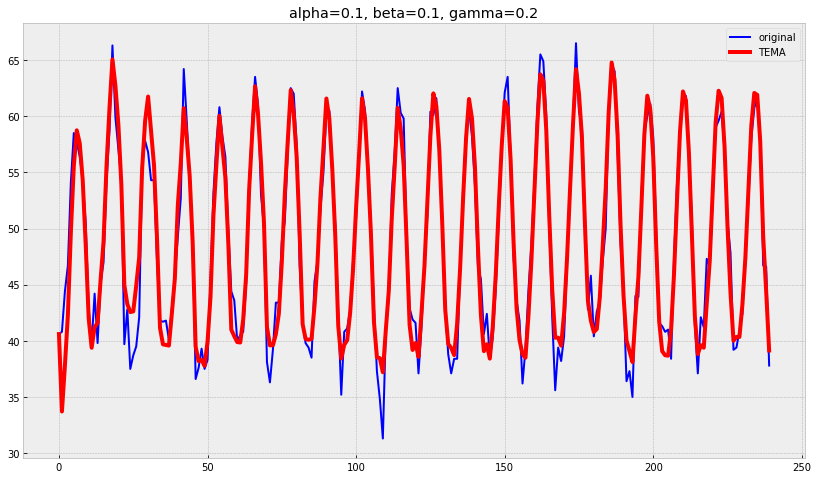

In [114]:
plot_tema(0.1, 0.1, 0.2)

**Попробуем подобрать лучшие параметры**

In [115]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [116]:
series = mean_monthly_temp['Deg']

In [117]:
series_num = len(series)
train_size = round(series_num*0.8)
train, test = series[:train_size], series[train_size:]

In [118]:
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [119]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [120]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 3.9622788523210546
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.64313008e-06,  1.50546242e-05, -1.42108547e-06])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 104
      nit: 23
   status: 0
  success: True
        x: array([0.35564206, 0.00196425, 0.06990713])


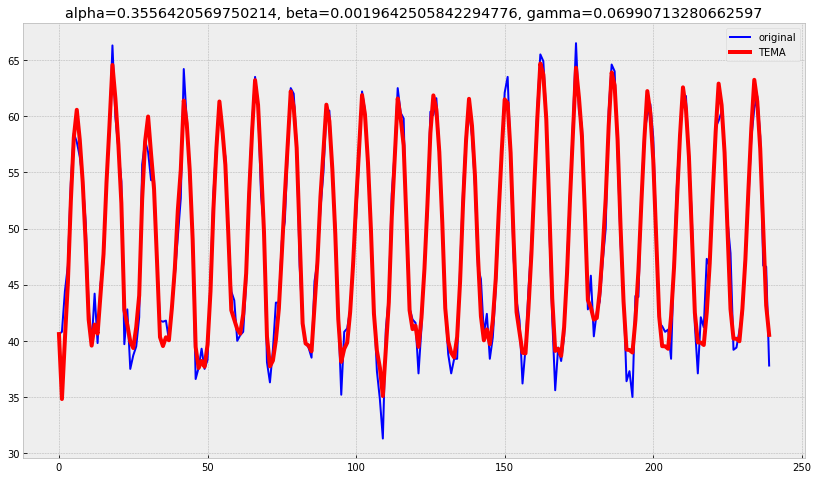

In [121]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series, n_preds=len(test))

**Оценим качество модели (методом MSE):**

In [122]:
opt.fun

3.9622788523210546

## Приближение стационарного ряда

In [125]:
from scipy.stats import boxcox

In [126]:
series = boxcox(mean_monthly_temp["Deg"], 0)

In [127]:
series = np.diff(series, 12)

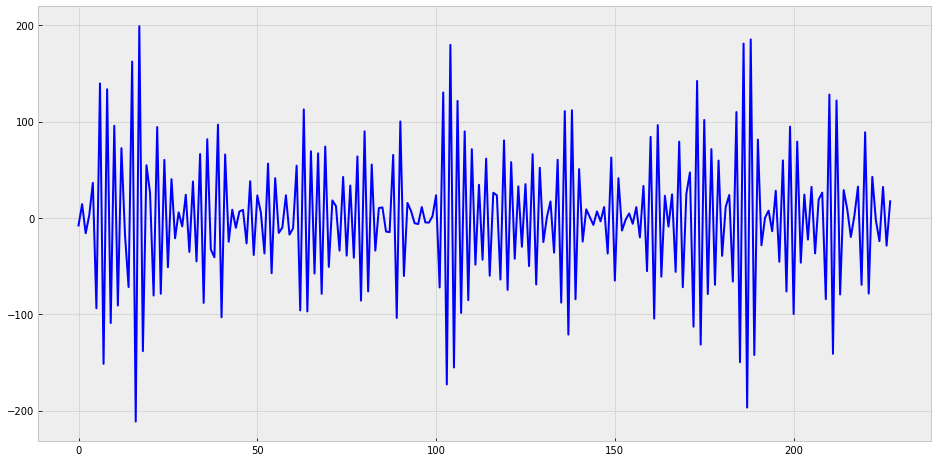

In [128]:
with plt.style.context('bmh'):
        plt.figure(figsize=(16, 8))
        plt.plot(series, color='blue')

**Так как в стационарном ряде нет трендов и сезонностей, возможно, достаточно будет метода EMA. Проверим это.**

In [129]:
series_num = len(series)
train_size = round(series_num*0.8)
train, test = series[:train_size], series[train_size:]

In [130]:
def exponential_moving_average(series, alpha, n_pred=None):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n-1] + (1 - alpha) * result[n-1])
    if not n_pred:
        return pd.Series(result)
    
    predictions = [alpha * series[len(series) - 1] + (1 - alpha) * result[-1]]

    for _ in range(n_pred):
        res = alpha * predictions[-1] + (1 - alpha) * result[-1]
        result.append(res)
        predictions.append(res)
    
    return result

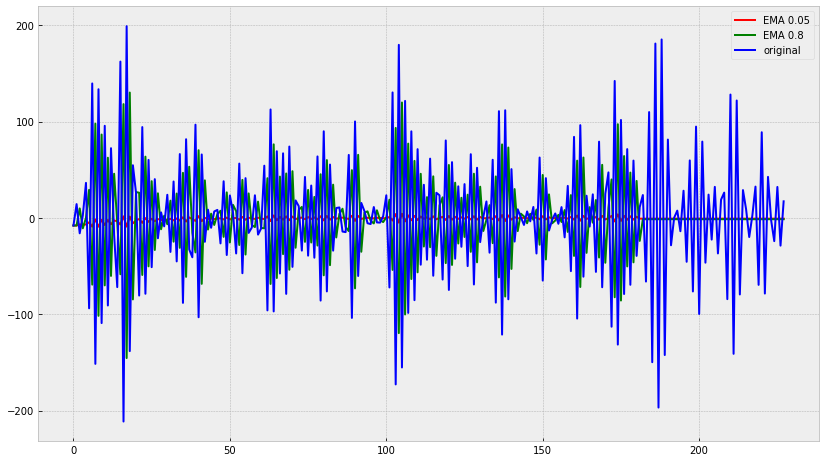

In [131]:
alphas = [0.05, 0.8]
colors = ['red', 'green']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    for i in range(len(alphas)):
        ser = exponential_moving_average(train, alphas[i], len(test))
        plt.plot(ser, color=colors[i], linewidth='2', label='EMA {}'.format(alphas[i]))
    plt.plot(series, color='blue',label='original')
    plt.legend()

**Оценим качество модели EMA для разных alpha:**

In [132]:
def mse_EMA(alpha):
    result = exponential_moving_average(train, alpha, n_pred=len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [133]:
for a in [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 0.9]:
    print(a, mse_EMA(a))

0.01 6700.597737131706
0.05 6698.857907398417
0.1 6700.372570859248
0.2 6705.660924953258
0.3 6712.956345373916
0.4 6720.3174708413
0.5 6724.907389244282
0.8 6700.183314757591
0.9 6708.88009464773


**Выводы:** по графику видно, что предсказания модели в итоге сводятся к среднему (нулю). Попробуем улучшить результаты более сложной моделью - TEMA: в отличии от DEMA она учитывает еще и сезонность, поэтому у нее больше шансов на хороший результат.

In [134]:
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [135]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [136]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 6503.002865574533
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00345608,  0.03428795, -0.01255103])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 188
      nit: 32
   status: 0
  success: True
        x: array([0.27962297, 0.02365627, 0.11311672])


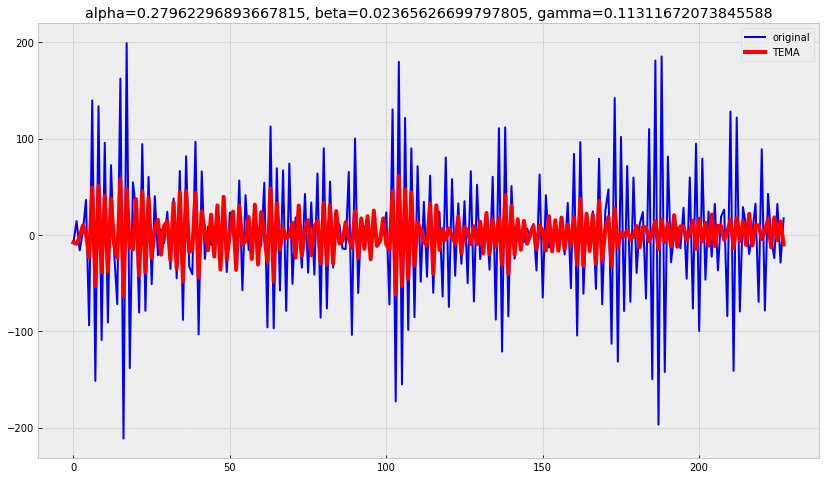

In [137]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series, n_preds=len(test))

**Выводы:** модель TEMA показывает лучший результат: ошибка MSE уменьшилась и предсказания выглядят более реалистичными (не сводятся к прямой линии). Большая величина ошибки может говорить о том, что данный класс моделей (MA) не подходит для предсказания значений стационарного ряда.